# DiffVAE methodology 

This notebook describes, step-by-step, how to use DiffVAE to identify cells in a dataset and to perform perturbations. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import pandas as pd
import matplotlib as mpl
import pickle

from sklearn.mixture import GaussianMixture
from sklearn.metrics import adjusted_rand_score, accuracy_score
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

import warnings
warnings.filterwarnings('ignore')

In [ ]:
from neural_network_models.neural_network import NeuralNetwork
from data.data_processing import get_zebrafish_gene_expression_data
from autoencoder_models.VAE_models import DisentangledDiffVAE
from evaluation.high_weight_genes import zebrafish_compute_high_weight_genes_latent_dim, zebrafish_compute_weights_latent_genes
from evaluation.latent_dim_metrics import compute_dif_capacity_clusters_latent_dim
from data.data_processing import get_zebrafish_genes
from collections import Counter
from neural_network_models.neural_network import NeuralNetwork

# Identify cell types using DiffVAE

## 1. Using DiffVAE to obtain cell clusters

In [ ]:
gene_data = get_zebrafish_gene_expression_data()

### 1.a Load trained DiffVAE model and compute the latent representation

For details how to train a DiffVAE model, see README.md

In [ ]:
latent_dimension = 50
DiffVAE_model = DisentangledDiffVAE(original_dim=gene_data.shape[1], latent_dim=latent_dimension, hidden_layers_dim=[512,256],
                batch_size=128, epochs=100, learning_rate=0.001)
DiffVAE_model_dim_reduction = DiffVAE_model.dimensionality_reduction(gene_data, 'Saved-Models/Encoders/diffvae_encoder_zebrafish50.h5')

### 1.b Compute the TSNE embedding of the latent representation

In [10]:
np.random.seed(5)
tsne_info = TSNE(n_components=2).fit_transform(DiffVAE_model_dim_reduction)

### 1.c Compute the cell clusters

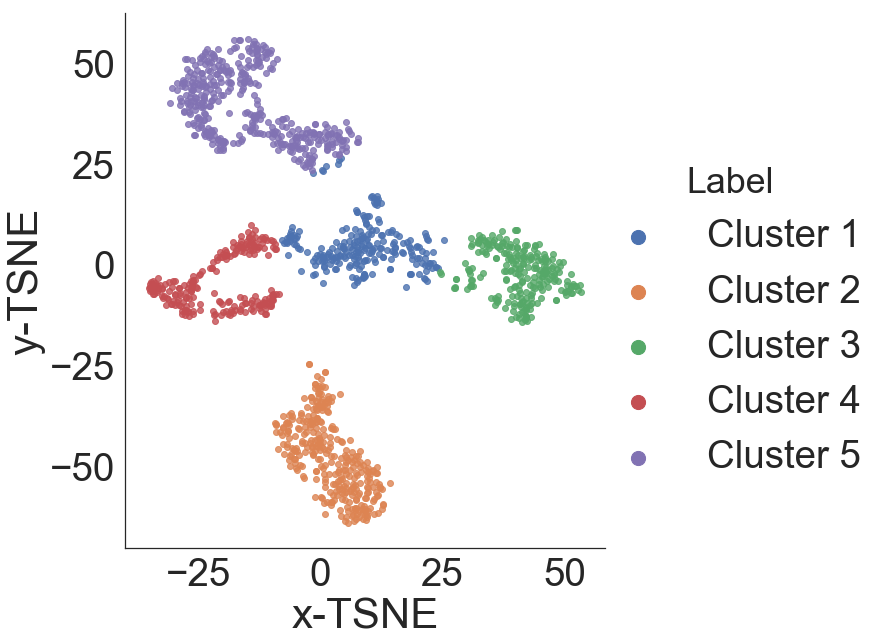

In [11]:
num_clusters = 5
sns.set(font_scale=3.5)
sns.set_style('white')
kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit_predict(tsne_info)
cluster_label = ['Cluster ' + str(i + 1) for i in kmeans]
info_vae_df = pd.DataFrame(data={'x-TSNE': tsne_info[:, 0], 'y-TSNE': tsne_info[:, 1], 'Label': cluster_label, 'Model': 'Disentangled-DiffVAE'})
sns_plot = sns.lmplot(data=info_vae_df, x='x-TSNE', y='y-TSNE', hue='Label', 
                      hue_order=['Cluster 1', 'Cluster 2', 'Cluster 3',  'Cluster 4', 'Cluster 5'],
                      fit_reg=False, size=10)

for lh in sns_plot._legend.legendHandles: 
    lh.set_alpha(1)
    lh._sizes = [200]

    
sns_plot.savefig('results/identify_cells/cells_tsne_cluster_labels.pdf')



## 2. Latent dimensions encoding cell differentiation
For each latent dimentions, compute the percentage distributions for the cells in each different cluster. This will help us evaluate how much each latent dimension encodes the differentiation of cells in each cluster. 


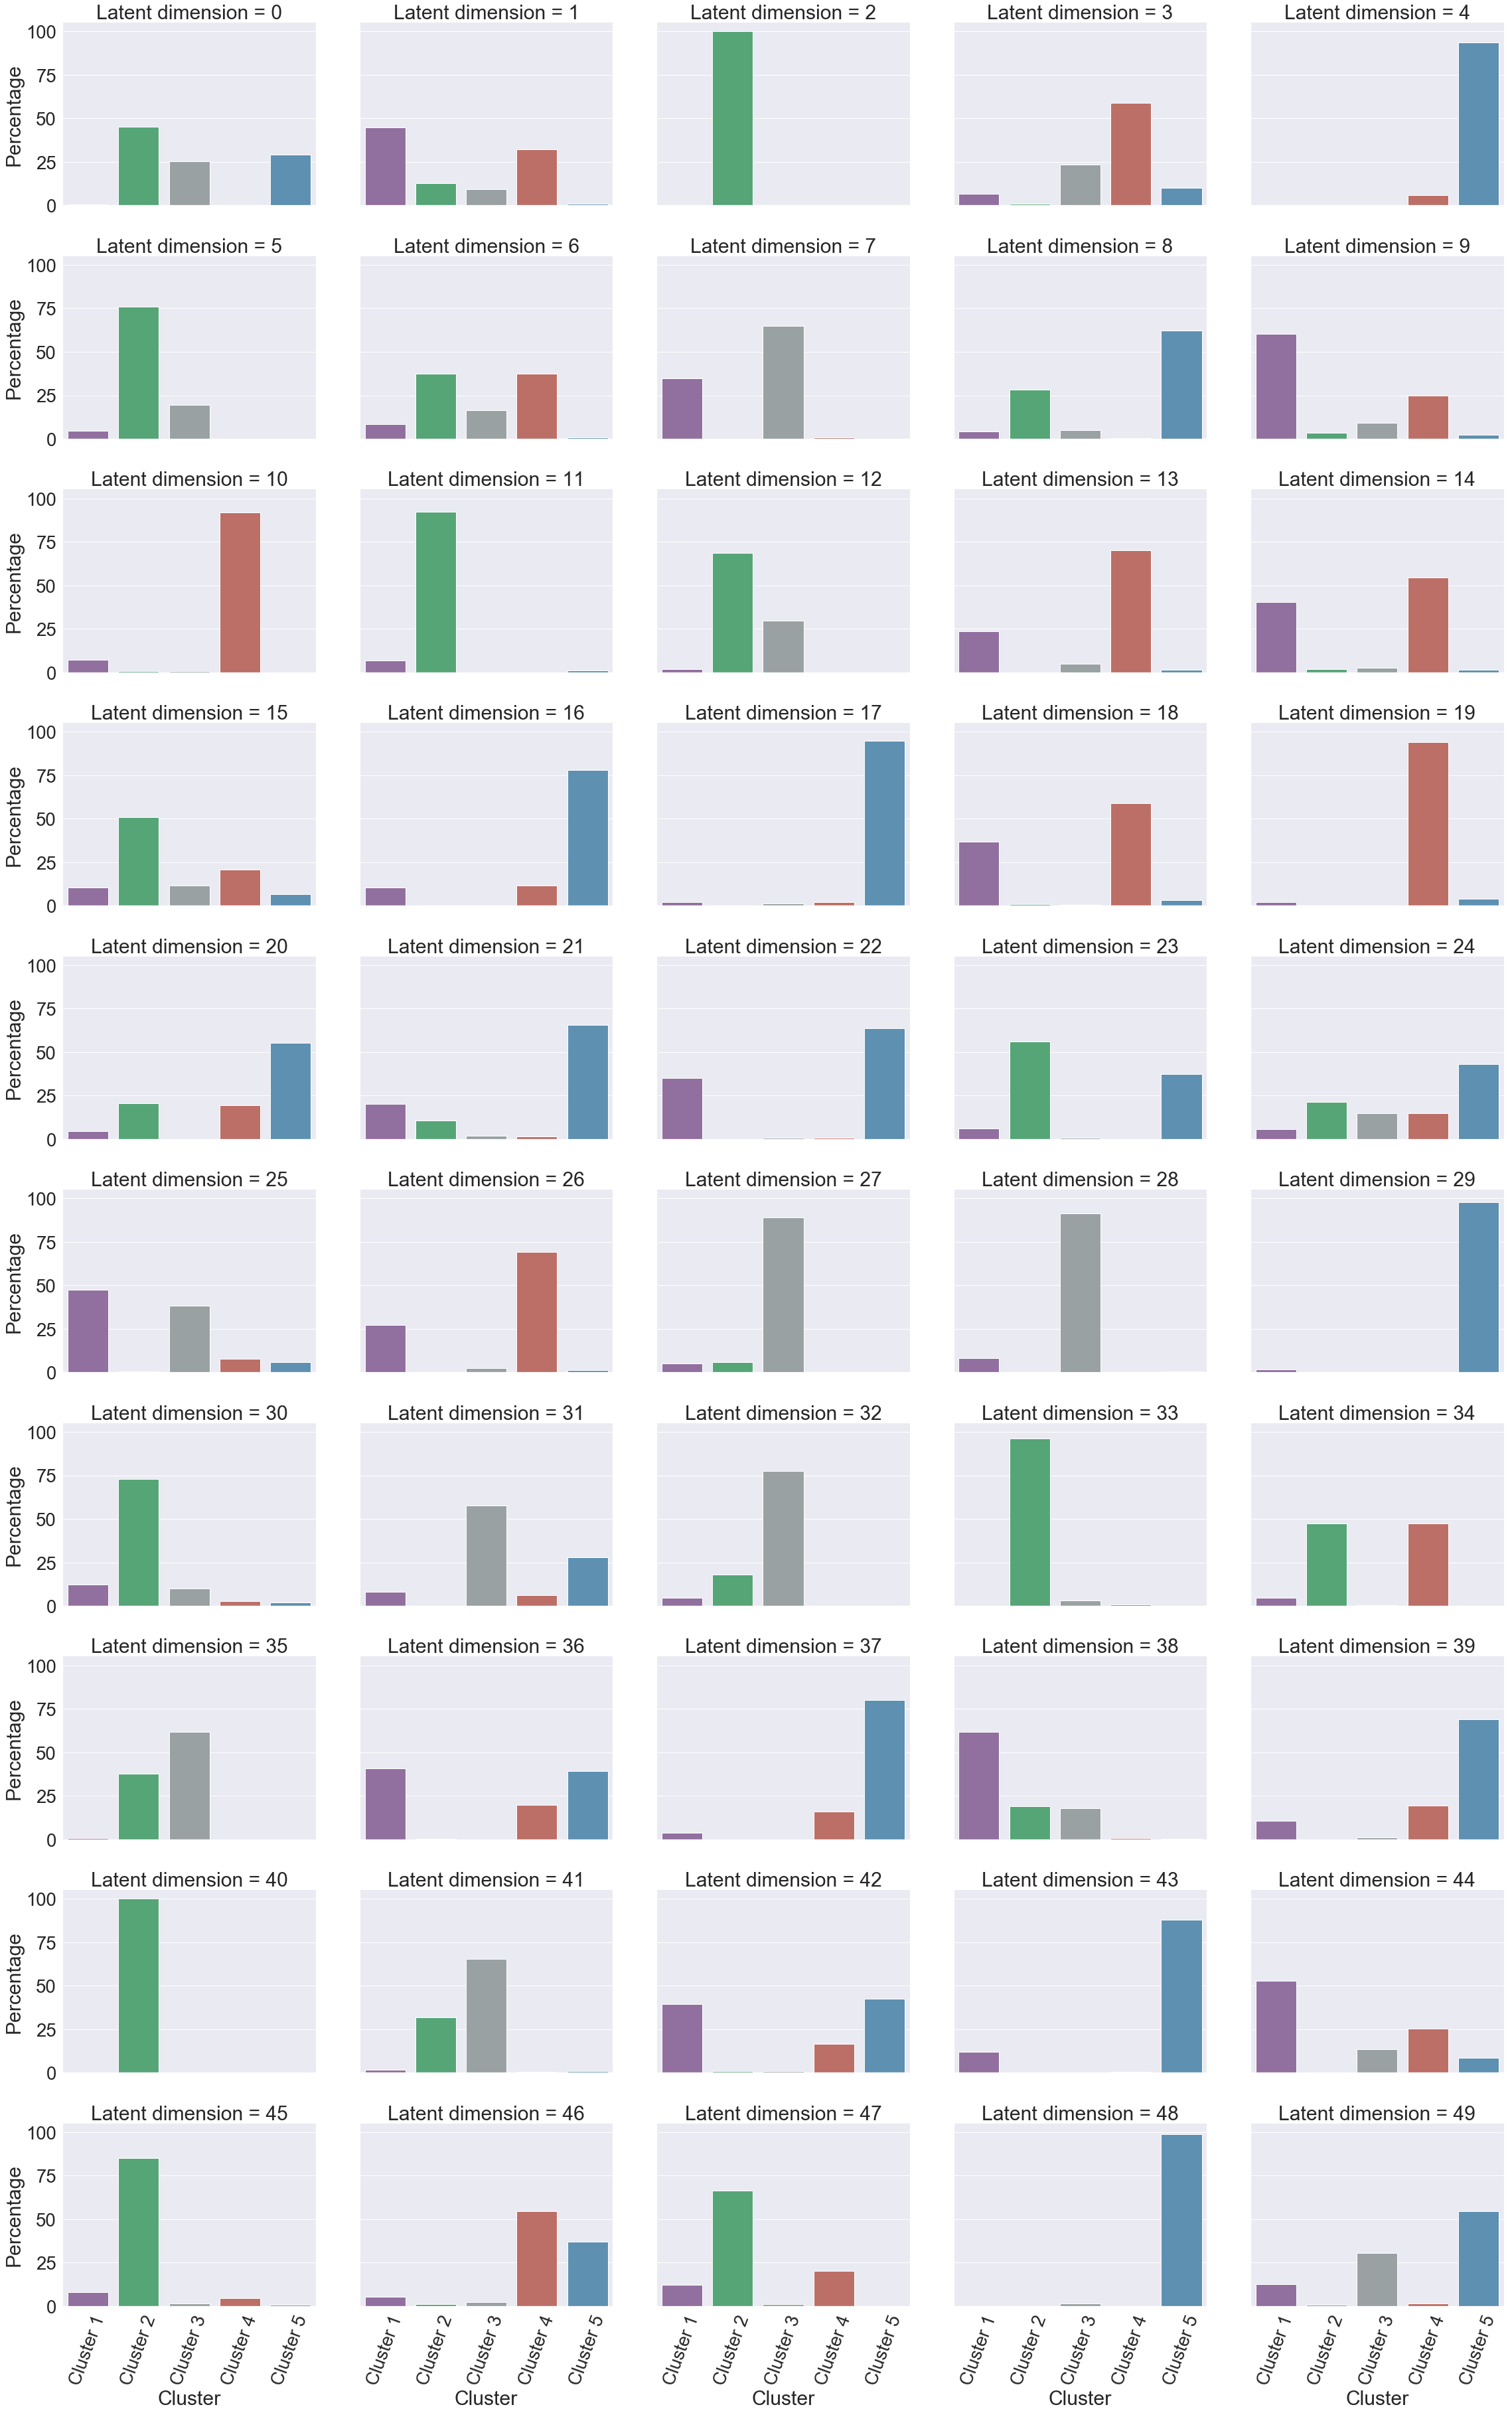

In [12]:
latent_diff = compute_dif_capacity_clusters_latent_dim(DiffVAE_model_dim_reduction, kmeans)

For each cluster, select the top 10 relevant latent dimensions. 

In [13]:
latent_diff_clusters =  latent_diff.sort_values(['Cluster','Percentage'],ascending=False).groupby('Cluster').head(10)

## 3. Compute high weight genes
For each latent dimension, use the top 3 high weight genes. 

In [14]:
weights_latent_genes = zebrafish_compute_weights_latent_genes('Saved-Models/Decoders/diffvae_decoder_zebrafish50.h5',
                                                              num_latent_dimensions=50, model='DisentangledDiffVAE')
gene_weights = zebrafish_compute_high_weight_genes_latent_dim(weights_latent_genes, latent_dimension=2, model='DisentangledDiffVAE')


In [15]:
cluster_labels = ['Cluster ' + str(i) for i in np.unique(kmeans)]

cluster_imp_genes = {}
for i in range(5):
    cluster_genes = []
    latent_diff_cluster = latent_diff_clusters[latent_diff_clusters['Cluster'] == 'Cluster ' + str(i+1)]
    for latent_dim_id in latent_diff_cluster['Latent dimension']:
        gene_weights = zebrafish_compute_high_weight_genes_latent_dim(weights_latent_genes, latent_dimension=latent_dim_id, model='DisentangledDiffVAE')
        cluster_genes.append((gene_weights[latent_dim_id].index.values[:3]))
    cluster_imp_genes[i+1] = np.unique((np.array(cluster_genes).flatten()))
    

In [16]:
cluster_imp_genes

{1: array(['anxa2a', 'aspm', 'ba1', 'blf', 'cad', 'cd74a', 'cebpa', 'fgfrl1a',
        'fn1b', 'hmgb1b', 'igfbp1a', 'itga2b', 'mibp', 'nanos1', 'npm1a',
        'pcna', 'pmp22b', 'prmt3', 'rgcc', 'rrm2', 's100a10b',
        'si:ch211-161c3.6', 'si:ch211-165i18.2', 'si:ch211-195b11.3',
        'si:xx-by187g17.1', 'tat', 'tgm2b', 'zgc:103700', 'zgc:136870'],
       dtype=object),
 2: array(['ANPEP', 'aspm', 'cfd', 'cfl1l', 'cpa5', 'ctssa', 'hmgn2',
        'hsd3b7', 'illr4', 'kif11', 'lyz', 'mmp13a', 'mmp9', 'npsn',
        'ponzr6', 'scpp8', 'si:ch1073-429i10.1'], dtype=object),
 3: array(['FCER2', 'c1qc', 'cd74a', 'cpa5', 'hp', 'illr4', 'lgals2a',
        'lgals3bpb', 'marco', 'ponzr6', 's100a10b', 's1pr4',
        'si:ch211-165i18.2', 'si:ch211-184m19.3', 'si:ch211-283g2.2',
        'si:dkey-193e13.8', 'si:dkey-29l4.4', 'zgc:136870'], dtype=object),
 4: array(['alas2', 'ba1', 'ba1l', 'blvrb', 'cad', 'dmtn', 'hbaa1', 'igfbp1a',
        'mibp', 'rgcc', 'rhag', 'si:ch211-103n10.5', 'si:c

In [18]:
kmeans_save = kmeans + 1
np.save("data/Zebrafish/Annotation_File_Clusters.npy", kmeans_save)

## 4. Map clusters to cell types
This is based on biological knowledge about marker genes for each cell type

In [19]:
cluster_mapping = {5: 'Thrombocytes', 4: 'Erythrocytes', 3:'Monocytes', 2:'Neutrophils', 1:'HSPCs'}

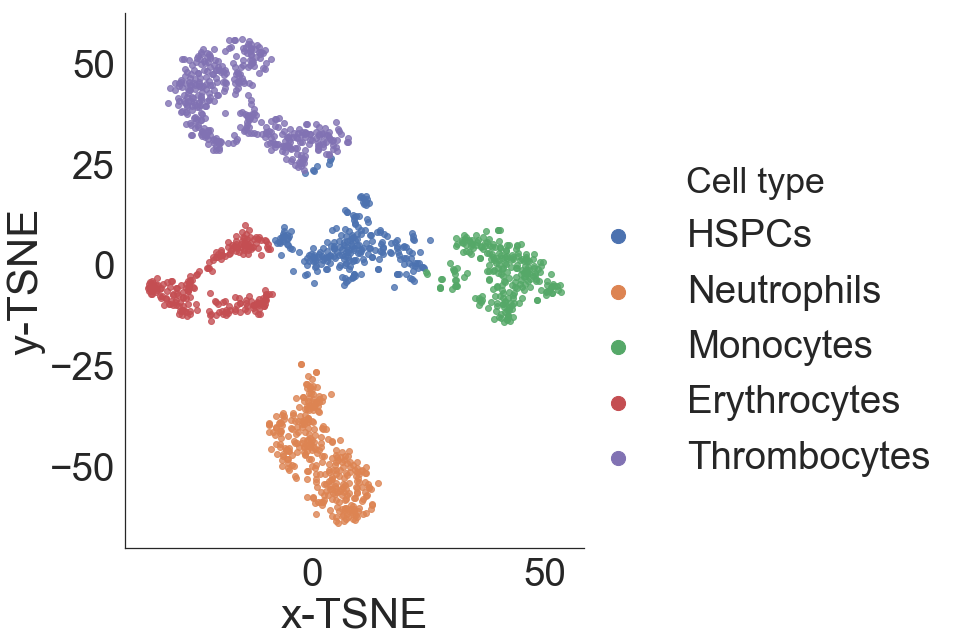

In [20]:
sns.set(font_scale=3.5)
sns.set_style('white')
cell_label = [cluster_mapping[i + 1] for i in kmeans]
info_vae_df = pd.DataFrame(data={'x-TSNE': tsne_info[:, 0], 'y-TSNE': tsne_info[:, 1], 'Cell type': cell_label, 'Model': 'Disentangled-DiffVAE'})
sns_plot = sns.lmplot(data=info_vae_df, x='x-TSNE', y='y-TSNE', hue='Cell type', 
                      hue_order=['HSPCs', 'Neutrophils', 'Monocytes', 'Erythrocytes', 'Thrombocytes'],
                      fit_reg=False, size=10)
for lh in sns_plot._legend.legendHandles: 
    lh.set_alpha(1)
    lh._sizes = [200]
    
sns_plot.savefig('results/identify_cells/cells_tsne_cell_labels.pdf')

# Navigating cell states

## Train neural network to distinguish between the differentiated cell types

In [21]:
kmeans_labels = kmeans
gene_data_diff = gene_data[np.where(kmeans_labels!=0)]
kmeans_labels_diff = kmeans_labels[np.where(kmeans_labels!=0)]   

In [24]:
NN_for_cells = NeuralNetwork(input_size=gene_data.shape[1], num_classes=4,
                                   hidden_layers_dim=[256, 512, 256], batch_size=128,
                                   epochs=300, learning_rate=0.001, dropout_probability=0.0)
#NN_for_cells.train_nn(gene_data_diff, kmeans_labels_diff, neural_network_filename='Saved-Models/NeuralNetworks/simple_nn.h5')
NN_for_cells.restore_neural_network('Saved-Models/NeuralNetworks/simple_nn.h5')

## Shift latent dimensions

In [25]:
def shift_latent_dimensions(data, num_std, latent_dimensions):
    for latent_dim in latent_dimensions:
        std = np.std([data[:,latent_dim]])
        data[:,latent_dim] = data[:,latent_dim] + float(num_std) * std
    return data


In [26]:
def change_cell_type(cell_data, num_std, latent_dimensions):
    cell_dim_reduction =  DiffVAE_model.dimensionality_reduction(cell_data,
                                                                 'Saved-Models/Encoders/diffvae_encoder_zebrafish50.h5')
    cell_shifted = shift_latent_dimensions(cell_dim_reduction, num_std, latent_dimensions)
    cell_reconstructed = DiffVAE_model.reconstruction(cell_shifted, 'Saved-Models/Decoders/diffvae_decoder_zebrafish50.h5')
    
    NN_predictions = np.argmax(NN_for_cells.nn_model.predict(cell_reconstructed), axis=1) + 1
    NN_prob_pred = np.max(NN_for_cells.nn_model.predict(cell_reconstructed), axis=1) 
    NN_predictions[np.where(NN_prob_pred < 0.5)[0]] = 0
   
    return NN_predictions, cell_reconstructed

In [27]:
# For each cell type we shift 5 latent dimentions
cluster_to_latend_dimensions_to_change = dict()
cluster_to_latend_dimensions_to_change[2] = [40, 33, 11, 45, 5] # Neutrophyls
cluster_to_latend_dimensions_to_change[3] = [28, 27, 32, 41, 7] # Monocytes
cluster_to_latend_dimensions_to_change[4] = [19, 10, 13, 26, 3] # Erythrocytes
cluster_to_latend_dimensions_to_change[5] = [48, 29, 17, 4, 43] # Thrombocytes

In [28]:
blue = (0.2980392156862745, 0.4470588235294118, 0.6901960784313725)
orange = (0.8666666666666667, 0.5176470588235295, 0.3215686274509804)
green = (0.3333333333333333, 0.6588235294117647, 0.40784313725490196)
red = (0.7686274509803922, 0.3058823529411765, 0.3215686274509804)
purple = (0.5058823529411764, 0.4470588235294118, 0.7019607843137254)
grey = (0.5490196078431373, 0.5490196078431373, 0.5490196078431373)

## Plot the HSPCs that were changed to a differentiated cell type

In [29]:
def plot_changing_cell_type(gene_data, kmeans_labels, cell_type, latent_dimensions_to_change):
    result_df = pd.DataFrame(columns=['x-TSNE', 'y-TSNE', 'Lambda', 'Cell type'])
    
    for index, lambda_std in enumerate([0.5, 1]):
        hspc_data = gene_data[np.where(kmeans_labels==0)[0]]
        NN_predictions, _ = change_cell_type(hspc_data, lambda_std, latent_dimensions_to_change) 
        NN_predictions[np.where(NN_predictions!=cell_type-1)[0]] = 0
        kmeans_labels_new = kmeans.copy()
        kmeans_labels_new[np.where(kmeans_labels==0)[0]] = NN_predictions
        kmeans_labels_new = kmeans_labels_new + 1
        cell_label = [(cluster_mapping[i]) for i in kmeans_labels_new]
        info_vae_df = pd.DataFrame(data={'x-TSNE': tsne_info[:, 0], 'y-TSNE': tsne_info[:, 1], 'Cell type': cell_label, 'Lambda': lambda_std})
                                    
        result_df = pd.concat([result_df, info_vae_df])
        
    sns.set(font_scale=3.5)
    sns.set_style('white')
    sns_plot = sns.lmplot(data=result_df, x='x-TSNE', y='y-TSNE', hue='Cell type', row='Lambda', 
                          hue_order=['HSPCs', 'Neutrophils', 'Monocytes', 'Erythrocytes', 'Thrombocytes'],
                          palette = [blue, grey, grey, red, grey], # These colors need to be changed depending on which cells are of interest 
                          fit_reg=False, size=10, legend=True)
    
    colors = [blue, orange, green, red, purple]
    for (index, lh) in enumerate(sns_plot._legend.legendHandles): 
        lh.set_alpha(1)
        lh.set_facecolor(colors[index])
        lh.set_edgecolor(colors[index])
        lh._sizes = [300]
        
        
    sns_plot.savefig('./results/identify_cells/change_cells' + str(cell_type) + '.pdf')

### Plot the HSPCs that changes into Erythrocytes

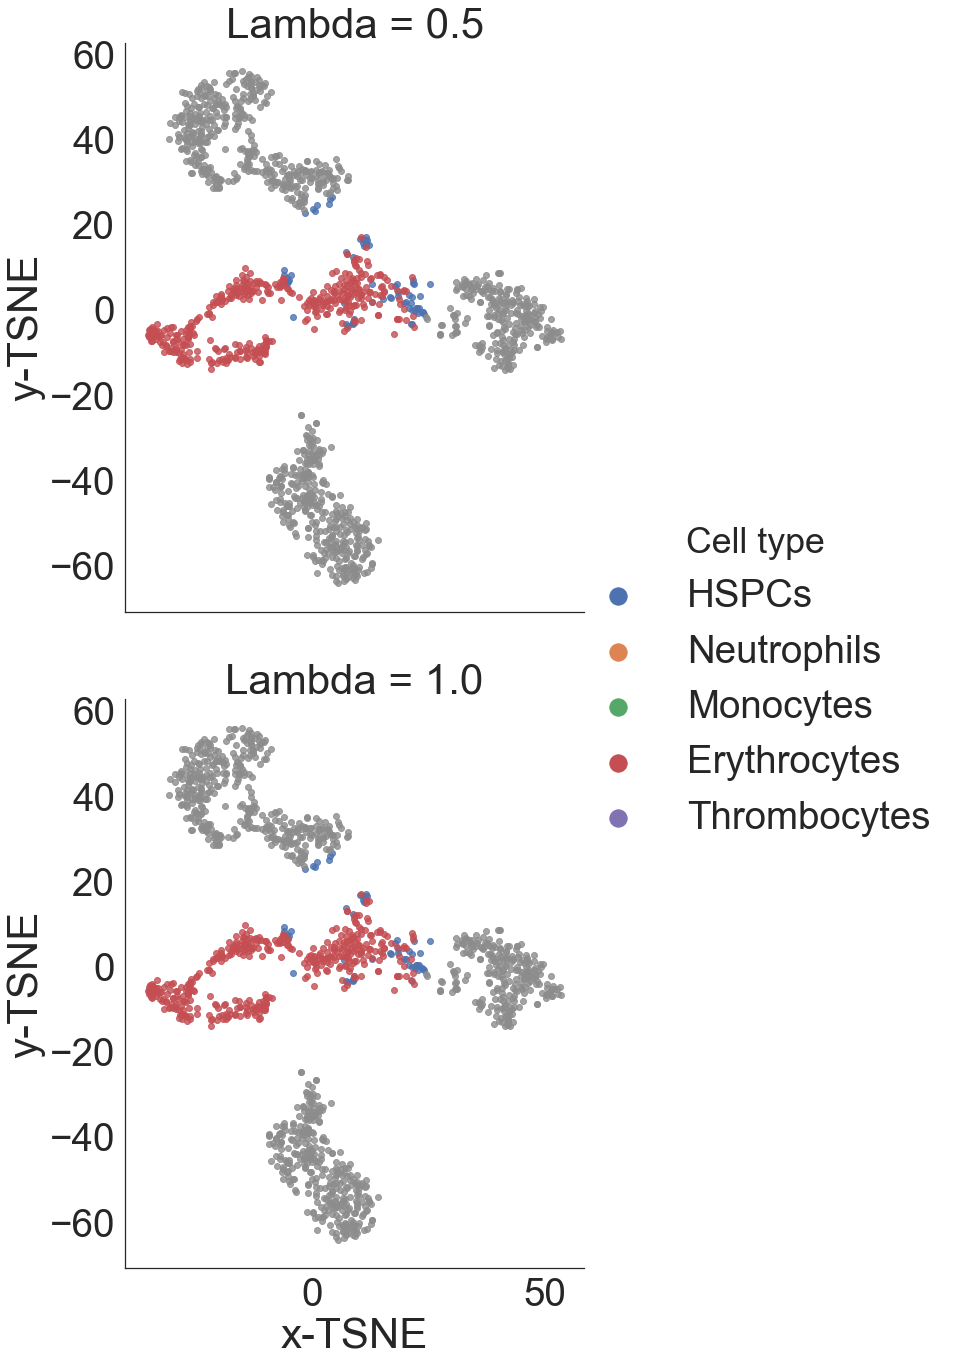

In [30]:
cell_type = 4
plot_changing_cell_type(gene_data, kmeans_labels, cell_type, cluster_to_latend_dimensions_to_change[cell_type])

## Analyze the genes that were changed after performing perturbations to the latent dimension

#### HSPCs -> Eryhtrocytes

In [31]:
hspc_data = gene_data[np.where(kmeans_labels==0)[0]]
lambda_std = 1.0
cell_type = 4
latent_dimensions_to_change = cluster_to_latend_dimensions_to_change[cell_type]

NN_predictions, cell_reconstructed = change_cell_type(hspc_data, lambda_std, latent_dimensions_to_change) 
NN_predictions[np.where(NN_predictions!=cell_type-1)[0]] = 0

In [32]:
hspc_data_changed = hspc_data[np.where(NN_predictions==cell_type-1)[0]]
cell_reconstructed_changed = cell_reconstructed[np.where(NN_predictions==cell_type-1)[0]]
gene_exp_diff = cell_reconstructed_changed - hspc_data_changed

In [33]:
hspc_data_experiment = hspc_data_changed.copy()
changed_genes = []
for i in range(gene_exp_diff.shape[0]):
    top_changed = np.argsort(np.abs(gene_exp_diff[i]))[-22:]
    changed_genes.append(top_changed)
    hspc_data_experiment[i][top_changed] = cell_reconstructed_changed[i][top_changed]
changed_genes = np.array(changed_genes)

In [34]:
pd.Series(changed_genes.flatten()).value_counts()[:10]

566     74
136     72
665     68
1533    65
1093    62
1386    59
404     54
663     36
834     31
1133    30
dtype: int64

In [35]:
genes = get_zebrafish_genes()

In [36]:
print (genes[136])
print (np.mean(gene_exp_diff[np.where(changed_genes == 136)[0], 136]))

npm1a
0.03293784743675673


In [37]:
print (genes[566])
print (np.mean(gene_exp_diff[np.where(changed_genes == 566)[0], 566]))

pcna
-0.07704236109676844


pcna is downregulated from HSPC to erythrocytes 
https://link.springer.com/article/10.1007%2Fs00418-005-0003-2

npm1a is upregulated from HSPC to erythrocytes
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2858496/